In [1]:
# Set the path
import sys
sys.path.append("../../")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, RampCurrentInjection
import act.data_processing as dp

import numpy as np
import matplotlib.pyplot as plt

from act.passive import ACTPassiveModule
from act.segregation import ACTSegregator

from sklearn.metrics import mean_absolute_error
from act.metrics import summary_features_error
import shutil

### Generate target data

In [31]:
# Define the "target" cell
target_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [3]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for amp_idx, amp in enumerate([0, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "target",
        sim_idx = amp_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        h_v_init = -40,
        CI = [ConstantCurrentInjection(amp = amp, dur = 700, delay = 100)]
        )

    simulator.submit_job(target_cell, sim_params)
    
simulator.run_jobs(3)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [4]:
dp.combine_data("output/target")

output/target/combined_out.npy


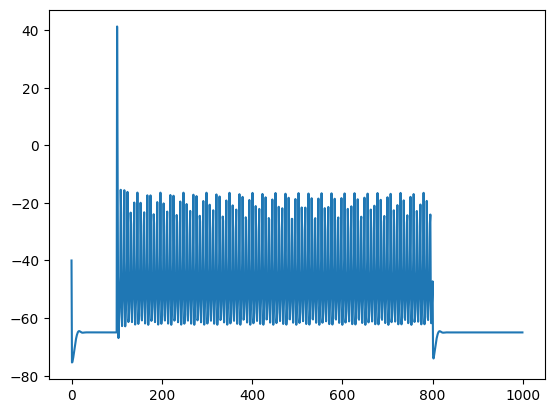

In [5]:
passive_trace = np.load("output/target/out_2.npy")[:, 0]
plt.plot(passive_trace[::10])

In [6]:
# Compute the error with respective target summary features
data = np.load(f"output/target/combined_out.npy")
V = data[:, ::10, 0].reshape((3, -1))
I = data[:, ::10, 1].reshape((3, -1))
summary_features_target = dp.get_summary_features(V, I, window = (100, 800))

In [7]:
# LTO: NaP, KM

def modify_template(spiking_th):
    
    spiking = [
        ("hh_spiker.mod", 111, spiking_th), 
        ("hh_spiker.mod", 130, spiking_th)
    ]

    for entry in spiking:
        with open(f"../../data/Spiker/orig_cutoff_test/modfiles/{entry[0]}", "r") as file:
            mod_file = file.readlines()

            sign = '<'
            mod_file[entry[1]] = "\t" + f"if (v {sign} {entry[2]}) " + "{\n"

        with open(f"../../data/Spiker/orig_cutoff_test/modfiles/{entry[0]}", "w") as file:
            file.writelines(mod_file)

In [9]:
modify_template(-2)

# Experiment

In [25]:
import os

def run_eval_single_simulation(current_injection, summary_features_target):

    assert len(current_injection) == 3

    # Define the cell
    cell = ACTCellModel(
        cell_name = "Spiker",
        path_to_hoc_file = "../../data/Spiker/orig_cutoff_test/target_template.hoc",
        path_to_mod_files = "../../data/Spiker/orig_cutoff_test/modfiles/",
        passive = ["gl", "el", None],
        active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
    )

    # Set simulations
    simulator = ACTSimulator(output_folder_name = "output")

    for inj_id, inj in enumerate(current_injection):
        sim_params = SimulationParameters(
            sim_name = "sim",
            sim_idx = inj_id,
            h_celsius = 6.3,
            h_dt = 0.1,
            h_tstop = 1000,
            h_v_init = -40,
            CI = [inj])

        simulator.submit_job(cell, sim_params)

    simulator.run_jobs(3)
    dp.combine_data("output/sim")

    # Get summary features
    data = np.load(f"output/sim/combined_out.npy")
    V = data[:, ::10, 0].reshape((3, -1))
    I = data[:, ::10, 1].reshape((3, -1))
    summary_features = dp.get_summary_features(V, I, window = (100, 800))

    # Clean
    shutil.rmtree("output/sim")

    return np.nanmean(summary_features_error(summary_features_target.to_numpy(), summary_features.to_numpy()))

In [26]:
# V-rest ~-70
all_errors = np.zeros(
    (
        len(np.arange(-80, 10, 5)), # Spiking
    )
) * np.nan

In [27]:
all_errors.shape

(18,)

In [ ]:
for idx_1, spiking_bound in enumerate(np.arange(-80, 10, 5)):
    # Set the bounds
    modify_template(spiking_th = spiking_bound)
    
    # Run a simulation with constant current injection
    error_const = run_eval_single_simulation(
        [
            ConstantCurrentInjection(amp = 0, dur = 700, delay = 100),
            ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100),
            ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100)
        ],
        summary_features_target
        )

    all_errors[idx_1] = error_const

In [29]:
np.savetxt("all_errors.txt", all_errors)

In [2]:
all_errors = np.loadtxt("all_errors.txt")

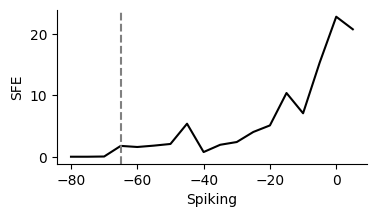

In [55]:
fig, ax = plt.subplots(1, 1, figsize = (4, 2))
ca = ax

ca.plot(np.arange(-80, 10, 5), all_errors, c = 'black')
ca.axvline(-65, ls = '--', c = 'gray')
ca.set_xlabel("Spiking")
ca.set_ylabel("SFE")
ca.spines['top'].set_visible(False)
ca.spines['right'].set_visible(False)

In [56]:
fig.savefig("Spiker-segregation_sweeps.png", bbox_inches = "tight", dpi = 500, format = "png")

In [13]:
v = np.arange(-80, 10, 5)
np.std(all_errors[v >= -20])

6.632493457048549